In [3]:
!pip install kaggle

In [4]:
!pip install fastai --upgrade

In [5]:
!pip install pydicom

     |████████████████████████████████| 2.0 MB 4.2 MB/s 


In [6]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jaycaceres1","key":"5d6c7bcb216a35f437729c82cbed0d85"}'}

In [8]:
from kaggle.api.kaggle_api_extended import KaggleApi

In [9]:
rm -r ~/.kaggle

In [10]:
mkdir ~/.kaggle

In [11]:
cp kaggle.json ~/.kaggle

In [12]:
! chmod 600 ~/.kaggle/kaggle.json

In [13]:
! kaggle datasets list 

ref                                                         title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-11-10 18:11:20          15691  
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01           9501  
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           4284  
dhruvildave/wikibooks-dataset                               Wikibooks Dataset                                   2GB  2021-10-22 10:48:21           3485  
promptcloud/careerbuilder-job-listing-2020                  Careerbuilder Jo

In [14]:
!kaggle datasets download -d jhoward/rsna-hemorrhage-jpg --force

 99% 3.80G/3.82G [01:45<00:00, 32.3MB/s]
100% 3.82G/3.82G [01:45<00:00, 38.8MB/s]


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from zipfile import ZipFile

In [16]:
!unzip rsna-hemorrhage-jpg.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_jpg/train_jpg/ID_f95a5acf1.jpg  
  inflating: train_jpg/train_jpg/ID_f95aab9b9.jpg  
  inflating: train_jpg/train_jpg/ID_f95aead46.jpg  
  inflating: train_jpg/train_jpg/ID_f95b1b2f3.jpg  
  inflating: train_jpg/train_jpg/ID_f95b84d72.jpg  
  inflating: train_jpg/train_jpg/ID_f95b92b87.jpg  
  inflating: train_jpg/train_jpg/ID_f95c5c81c.jpg  
  inflating: train_jpg/train_jpg/ID_f95c6f8dc.jpg  
  inflating: train_jpg/train_jpg/ID_f95c753dd.jpg  
  inflating: train_jpg/train_jpg/ID_f95c760db.jpg  
  inflating: train_jpg/train_jpg/ID_f95ce62ee.jpg  
  inflating: train_jpg/train_jpg/ID_f95d00a82.jpg  
  inflating: train_jpg/train_jpg/ID_f95d1d45b.jpg  
  inflating: train_jpg/train_jpg/ID_f95d4cfcf.jpg  
  inflating: train_jpg/train_jpg/ID_f95d6fed6.jpg  
  inflating: train_jpg/train_jpg/ID_f95dab24a.jpg  
  inflating: train_jpg/train_jpg/ID_f95e2044e.jpg  
  inflating: train_jpg/train_jpg/ID_f95e79cff.jpg  
  inflating: 

In [17]:
!unzip new_labels.csv.zip

Archive:  new_labels.csv.zip
  inflating: new_labels.csv          


In [18]:
from fastai import *
from fastai.vision.all import *
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
import pydicom
import glob
import pandas as pd


In [19]:
trn_path = Path('train_jpg/train_jpg/')
csv_path = Path('meta/meta/')

In [20]:
labels = pd.read_csv(csv_path/'new_labels.csv')
labels.head()

,Unnamed: 0,ID,epidural,intraparenchymal,intraventricular,subarachnoid,subdural,multi
0,0,ID_0002081b6.jpg,0,intraparenchymal,0,0,0,intraparenchymal
1,1,ID_0002a38ad.jpg,0,0,0,subarachnoid,subdural,subarachnoid;subdural
2,2,ID_000346ce2.jpg,0,0,0,0,subdural,subdural
3,3,ID_00042829c.jpg,0,0,intraventricular,0,0,intraventricular
4,4,ID_0004a5701.jpg,0,0,0,0,subdural,subdural


In [21]:
labels.columns

Index(['Unnamed: 0', 'ID', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural', 'multi'],
      dtype='object')

In [22]:
labels = labels.drop(['Unnamed: 0', 'epidural', 'intraparenchymal', 'intraventricular',
       'subarachnoid', 'subdural'], axis = 1)
labels.head()

,ID,multi
0,ID_0002081b6.jpg,intraparenchymal
1,ID_0002a38ad.jpg,subarachnoid;subdural
2,ID_000346ce2.jpg,subdural
3,ID_00042829c.jpg,intraventricular
4,ID_0004a5701.jpg,subdural


In [25]:
def get_sizes(size, bs):
    tfms = L([FlipItem(p = 0.2), Rotate(max_deg=30),Contrast(max_lighting=0.75, p=0.75)])
    return ImageDataLoaders.from_df(labels, trn_path, label_delim=';', item_tfms=Resize(size), batch_tfms=tfms, bs = bs, seed = 10)

In [26]:
size_64 = get_sizes(64, 512)

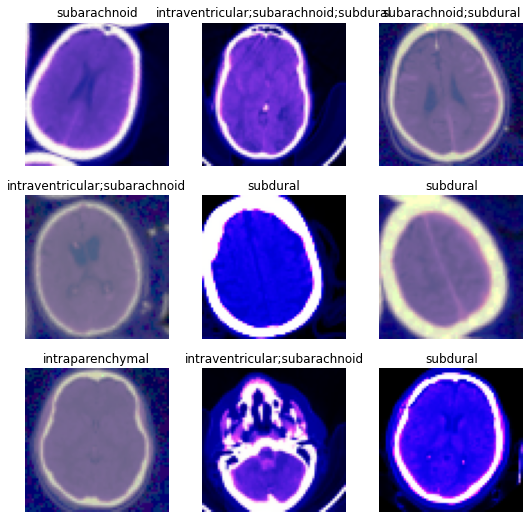

In [27]:
size_64.show_batch()

In [28]:
len(size_64.train_ds), len(size_64.valid_ds), size_64.bs
#97041

(77633, 19408, 512)

In [29]:
learn = cnn_learner(size_64, resnet50,pretrained=False, metrics=partial(accuracy_multi, thresh=0.5), model_dir = '/kaggle')

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.582607,0.530450,0.708780,02:50


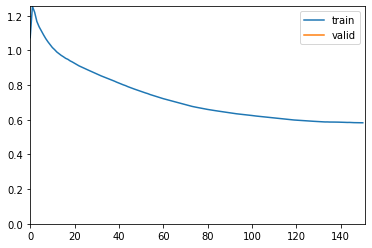

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.516486,0.494402,0.744116,02:41
1,0.499524,0.471169,0.761511,02:42
2,0.483475,0.462757,0.767354,02:41
3,0.467557,0.454877,0.776639,02:42
4,0.459213,0.451031,0.780544,02:42


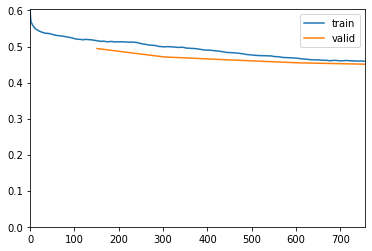

In [30]:
learn.fine_tune(5, base_lr= 2e-2,cbs=[ShowGraphCallback()])

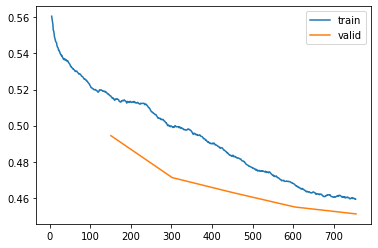

In [31]:
learn.recorder.plot_loss()

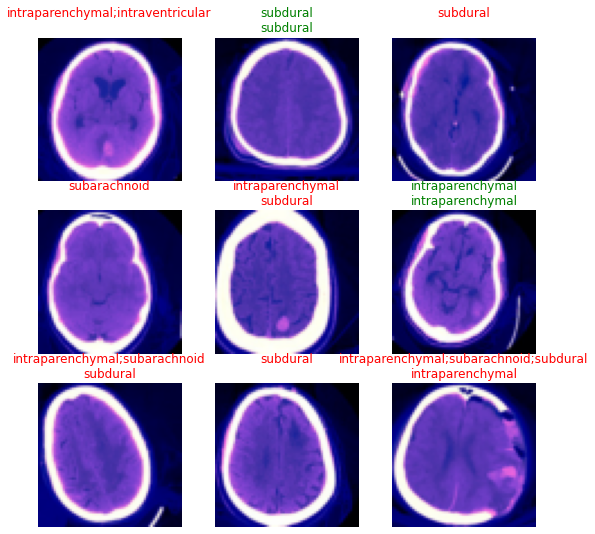

In [32]:
learn.show_results()

In [33]:
learn.dls = get_sizes(128, 256)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.439217,0.551624,0.755276,03:18
1,0.378636,0.434027,0.818662,03:15
2,0.334856,0.343909,0.848114,03:15
3,0.302193,0.284289,0.878421,03:16
4,0.280224,0.273055,0.883708,03:15


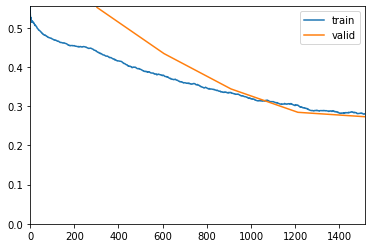

In [34]:
learn.fit_one_cycle(5, lr_max=1e-3,cbs=[ShowGraphCallback()])

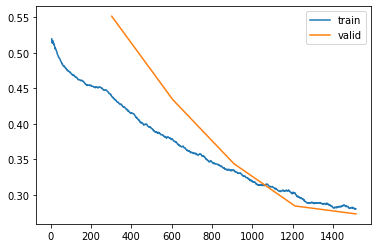

In [35]:
learn.recorder.plot_loss()

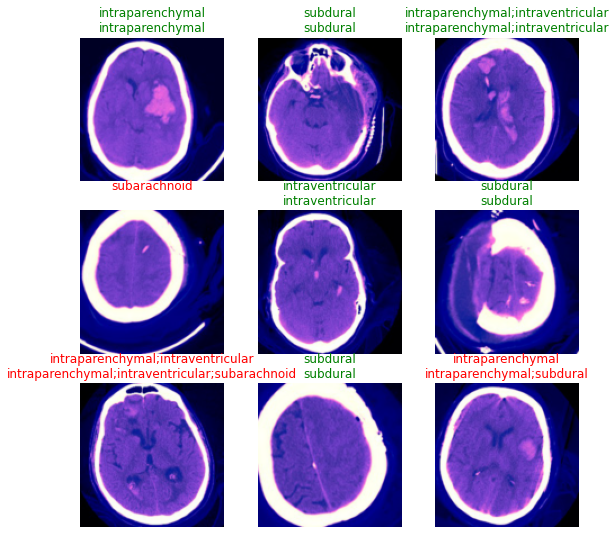

In [36]:
learn.show_results()

In [37]:
learn.dls = get_sizes(256, 64)

In [38]:
learn.fit_one_cycle(4, lr_max = 1e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.309253,0.292193,0.875598,10:23
1,0.283477,0.274886,0.883193,10:21
2,0.264148,0.255865,0.893776,10:21
3,0.256417,0.247252,0.897146,10:21


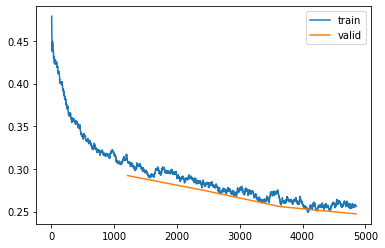

In [39]:
learn.recorder.plot_loss()

In [40]:
learn.save("/content/cnn_multilabel_RSNA_untrained_with_augsNEW")

Path('/content/cnn_multilabel_RSNA_untrained_with_augsNEW.pth')

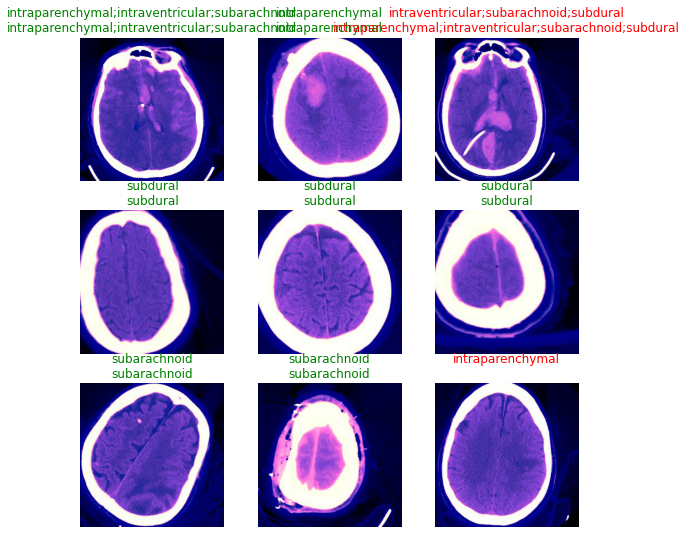

In [41]:
learn.show_results(ds_idx=1)

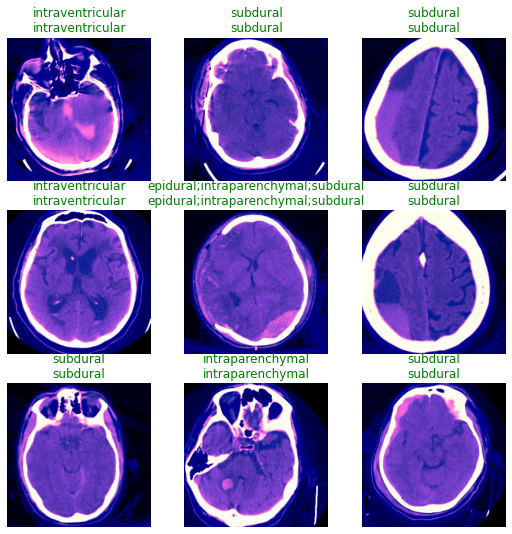

In [44]:
learn.show_results()